In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import GridSearchCV, KFold
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor

In [4]:
file = './seafood_data_junho/고등어.csv'

In [5]:
file = pd.read_csv(file)

In [6]:
df = pd.DataFrame(file)

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9894 entries, 0 to 9893
Data columns (total 8 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   날짜      9894 non-null   object 
 1   어종      9894 non-null   object 
 2   산지      9894 non-null   object 
 3   규격      9894 non-null   object 
 4   포장      9894 non-null   object 
 5   수량      9894 non-null   object 
 6   중량      9894 non-null   float64
 7   평균가     9894 non-null   object 
dtypes: float64(1), object(7)
memory usage: 618.5+ KB


In [8]:
df.columns

Index(['날짜', '어종', '산지', '규격', '포장', '수량', '중량', '평균가'], dtype='object')

In [9]:
df.columns = ['date', 'species', 'origin', 'standard', 'unit', 'amount', 'weight', 'avg_price']

In [10]:
# df = df.drop('unit', axis=1)

In [11]:
df.describe()

,weight
count,9894.000000
mean,13.863938
std,4.632411
min,1.000000
25%,10.000000
50%,15.000000
75%,15.000000
max,200.000000


## 데이터타입 변환

### 평균가에 , 기호 없애기

In [12]:
df['avg_price'] = df.avg_price.str.replace(',', '').astype('int')

### 수량에 , 기호 없애기

In [13]:
df['amount'] = df.amount.str.replace(',', '').astype('int')

### 날짜 데이터 년, 월, 일로 나누고 int형으로 변환

In [14]:
df['yyyy'], df['mm'], df['dd'] = df['date'].str.split('-').str

In [15]:
df.head()

,date,species,origin,standard,unit,amount,weight,avg_price,yyyy,mm,dd
0,2017-01-02,(냉)고등어,노르웨이,중,S/P,6,10.0,62500,2017,01,02
1,2017-01-02,(선)고등어,부산(기장),20미,S/P,3,10.0,40000,2017,01,02
2,2017-01-02,(선)고등어,부산(기장),20미,S/P,652,15.0,31800,2017,01,02
3,2017-01-02,(선)고등어,부산(기장),20미,S/P,70,20.0,45000,2017,01,02
4,2017-01-02,(선)고등어,부산(기장),22미,S/P,2,15.0,10000,2017,01,02


In [16]:
df = df.drop('date', axis=1)

In [17]:
for i in ['yyyy', 'mm', 'dd']:
  df[i] = list(map(int, df[i]))

In [18]:
df.dtypes

species       object
origin        object
standard      object
unit          object
amount         int32
weight       float64
avg_price      int32
yyyy           int64
mm             int64
dd             int64
dtype: object

#### 년 / 월 / 일 별 가격변동

<AxesSubplot:xlabel='dd'>

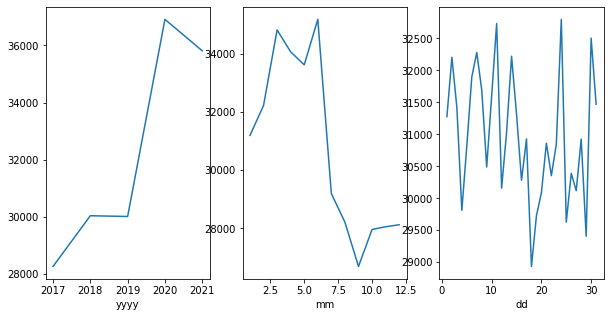

In [19]:
plt.figure(figsize=(10, 5))

plt.subplot(131)
Years = df.groupby('yyyy').mean()
Years['avg_price'].plot(x=df.yyyy)
plt.subplot(132)
Months = df.groupby('mm').mean()
Months['avg_price'].plot(x=df.mm)
plt.subplot(133)
Days = df.groupby('dd').mean()
Days['avg_price'].plot(x=df.dd)

#### 산지별 가격분포

Text(0, 0.5, 'origin')

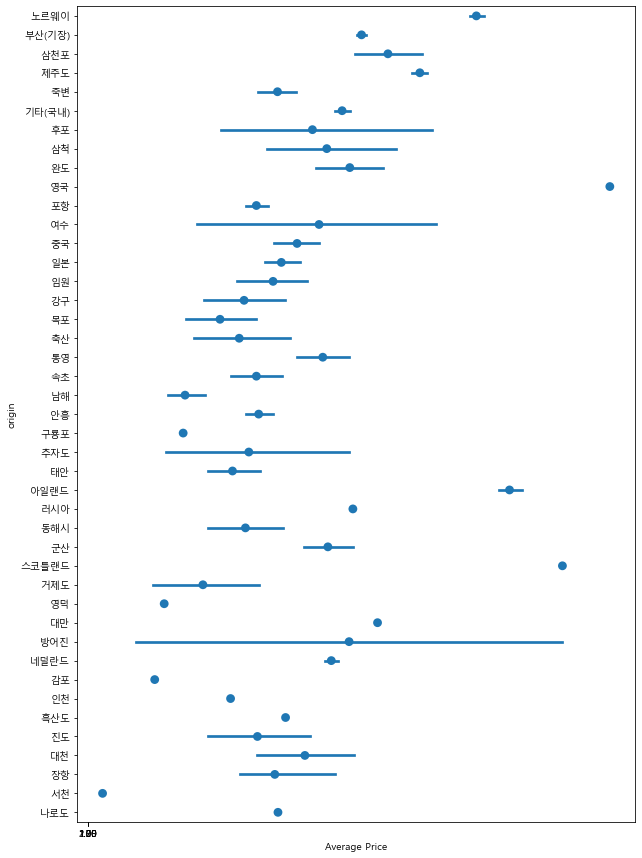

In [20]:
plt.rcParams['font.family']= 'Malgun Gothic'

plt.figure(figsize=(10, 15))
sns.pointplot(x='avg_price', y='origin', data=df, join=False)
plt.xticks(np.linspace(1, 2, 5))
plt.xlabel('Average Price')
plt.ylabel('origin')

In [21]:
gd_pdf = df[df.species=='(선)고등어']

In [22]:
gd_pdf.head()

,species,origin,standard,unit,amount,weight,avg_price,yyyy,mm,dd
1,(선)고등어,부산(기장),20미,S/P,3,10.0,40000,2017,1,2
2,(선)고등어,부산(기장),20미,S/P,652,15.0,31800,2017,1,2
3,(선)고등어,부산(기장),20미,S/P,70,20.0,45000,2017,1,2
4,(선)고등어,부산(기장),22미,S/P,2,15.0,10000,2017,1,2
5,(선)고등어,부산(기장),24미,S/P,48,15.0,27500,2017,1,2


In [23]:
gd_pdf['origin'].count()

5895

In [24]:
gd_pdf['origin'].value_counts()

부산(기장)    2894
제주도       1913
포항         184
안흥         153
삼천포        112
죽변          81
통영          80
군산          72
속초          57
일본          47
태안          39
완도          39
목포          33
남해          29
임원          25
축산          22
동해시         19
삼척          17
대천          15
강구          13
후포           9
추자도          8
거제도          6
진도           6
여수           4
나로도          4
기타(국내)       3
장항           3
방어진          2
구룡포          1
영덕           1
감포           1
인천           1
흑산도          1
서천           1
Name: origin, dtype: int64

### 100 이상을 차지하는 부산(기장), 제주도, 포항, 안흥, 삼천포만을 두고 제외하기

In [25]:
origin_mask = (gd_pdf.origin == '부산(기장)')|(gd_pdf.origin == '제주도')|(gd_pdf.origin == '포항')|(gd_pdf.origin == '안흥')|(gd_pdf.origin == '삼천포')


gd_pdf = gd_pdf.loc[origin_mask, :]

In [26]:
gd_pdf['origin'].value_counts()

부산(기장)    2894
제주도       1913
포항         184
안흥         153
삼천포        112
Name: origin, dtype: int64

In [27]:
gd_pdf['standard'].value_counts()

20미       698
중         607
18미       417
28미       368
24미       349
26미       319
12미       294
22미       288
15미       258
30미       231
10미       189
14미       159
35미       155
16미       152
32미        84
13미        83
40미        68
34미        63
대          53
8미         51
38미        47
17미        41
25미        36
11미        34
소          31
21미        22
9미         17
19미        16
36미        15
바라         15
23미        11
7미         11
6미         11
48미        10
33미         7
42미         7
파치          6
27미         4
46미         4
특대          4
37미         3
5미          3
4미          3
29미         1
10/12       1
47미         1
45미         1
12/13미      1
44미         1
3미          1
1미          1
11/12미      1
12/15       1
19/20미      1
13/14미      1
Name: standard, dtype: int64

In [28]:
gd_pdf[gd_pdf.standard=='중']

,species,origin,standard,unit,amount,weight,avg_price,yyyy,mm,dd
12,(선)고등어,부산(기장),중,S/P,3,10.0,45000,2017,1,2
15,(선)고등어,제주도,중,S/P,6,13.0,20800,2017,1,2
25,(선)고등어,부산(기장),중,S/P,1,15.0,5000,2017,1,3
26,(선)고등어,제주도,중,S/P,14,13.0,20100,2017,1,3
35,(선)고등어,부산(기장),중,S/P,140,15.0,13000,2017,1,4
...,...,...,...,...,...,...,...,...,...,...
9806,(선)고등어,안흥,중,kg,5,5.0,4000,2021,11,9
9842,(선)고등어,제주도,중,S/P,4,15.0,20000,2021,11,30
9846,(선)고등어,제주도,중,S/P,10,15.0,12000,2021,12,2
9884,(선)고등어,제주도,중,S/P,2,15.0,38000,2021,12,23


In [29]:
standard_mask = (gd_pdf.standard == '20미')|(gd_pdf.standard == '중')|(gd_pdf.standard == '18미')|(gd_pdf.standard == '28미')


gd_pdf = gd_pdf.loc[standard_mask, :]

In [30]:
gd_pdf['standard'].value_counts()

20미    698
중      607
18미    417
28미    368
Name: standard, dtype: int64

#### 추려낸 위 규격에서 가장 많은 포장을 차지하는 S/P포장으로 단일화

In [31]:
gd_pdf = gd_pdf[gd_pdf.unit=='S/P']

In [32]:
gd_pdf.head(3)

,species,origin,standard,unit,amount,weight,avg_price,yyyy,mm,dd
1,(선)고등어,부산(기장),20미,S/P,3,10.0,40000,2017,1,2
2,(선)고등어,부산(기장),20미,S/P,652,15.0,31800,2017,1,2
3,(선)고등어,부산(기장),20미,S/P,70,20.0,45000,2017,1,2


In [33]:
gd_pdf = gd_pdf.drop(['species', 'unit'], axis=1)

gd_pdf.head()

,origin,standard,amount,weight,avg_price,yyyy,mm,dd
1,부산(기장),20미,3,10.0,40000,2017,1,2
2,부산(기장),20미,652,15.0,31800,2017,1,2
3,부산(기장),20미,70,20.0,45000,2017,1,2
7,부산(기장),28미,71,15.0,10000,2017,1,2
8,부산(기장),28미,80,20.0,14000,2017,1,2


### 범주형 데이터 OHE 수행

In [34]:
gd_pdf = pd.get_dummies(gd_pdf, columns=['origin', 'standard'])

In [35]:
gd_pdf.head(3)

,amount,weight,avg_price,yyyy,mm,dd,origin_부산(기장),origin_삼천포,origin_안흥,origin_제주도,origin_포항,standard_18미,standard_20미,standard_28미,standard_중
1,3,10.0,40000,2017,1,2,1,0,0,0,0,0,1,0,0
2,652,15.0,31800,2017,1,2,1,0,0,0,0,0,1,0,0
3,70,20.0,45000,2017,1,2,1,0,0,0,0,0,1,0,0


In [36]:
gd_pdf.describe()

,amount,weight,avg_price,yyyy,mm,dd,origin_부산(기장),origin_삼천포,origin_안흥,origin_제주도,origin_포항,standard_18미,standard_20미,standard_28미,standard_중
count,2043.000000,2043.000000,2043.000000,2043.000000,2043.000000,2043.000000,2043.000000,2043.000000,2043.000000,2043.000000,2043.000000,2043.000000,2043.000000,2043.000000,2043.000000
mean,166.209496,14.694077,36584.777288,2018.174254,6.678414,15.752814,0.580029,0.025942,0.011747,0.336760,0.045521,0.203133,0.339207,0.179638,0.278023
std,290.231297,4.196087,18837.835942,1.170977,3.377615,8.645657,0.493675,0.159002,0.107773,0.472718,0.208496,0.402429,0.473556,0.383979,0.448134
min,1.000000,1.000000,2000.000000,2017.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,12.000000,13.000000,22000.000000,2017.000000,4.000000,8.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,51.000000,15.000000,34900.000000,2018.000000,7.000000,16.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,179.000000,15.000000,49400.000000,2019.000000,9.000000,23.000000,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,1.000000,0.000000,1.000000
max,2586.000000,143.000000,120000.000000,2021.000000,12.000000,31.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


## 시각화

In [37]:
num_cols = ['amount', 'weight', 'avg_price', 'yyyy', 'mm', 'dd']
num_gd_pdf = gd_pdf[num_cols]

<AxesSubplot:>

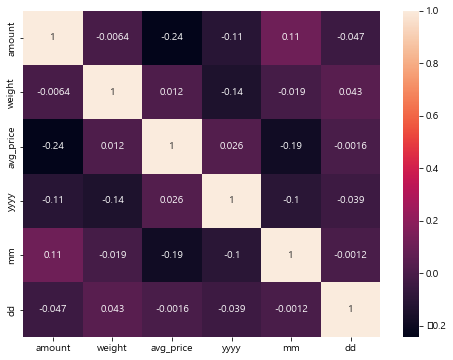

In [38]:
plt.figure(figsize=(8, 6))
sns.heatmap(num_gd_pdf.corr(), annot=True)

In [39]:
print(gd_pdf.columns)
print("컬럼 수 :", len(gd_pdf.columns))

Index(['amount', 'weight', 'avg_price', 'yyyy', 'mm', 'dd', 'origin_부산(기장)',
       'origin_삼천포', 'origin_안흥', 'origin_제주도', 'origin_포항', 'standard_18미',
       'standard_20미', 'standard_28미', 'standard_중'],
      dtype='object')
컬럼 수 : 15


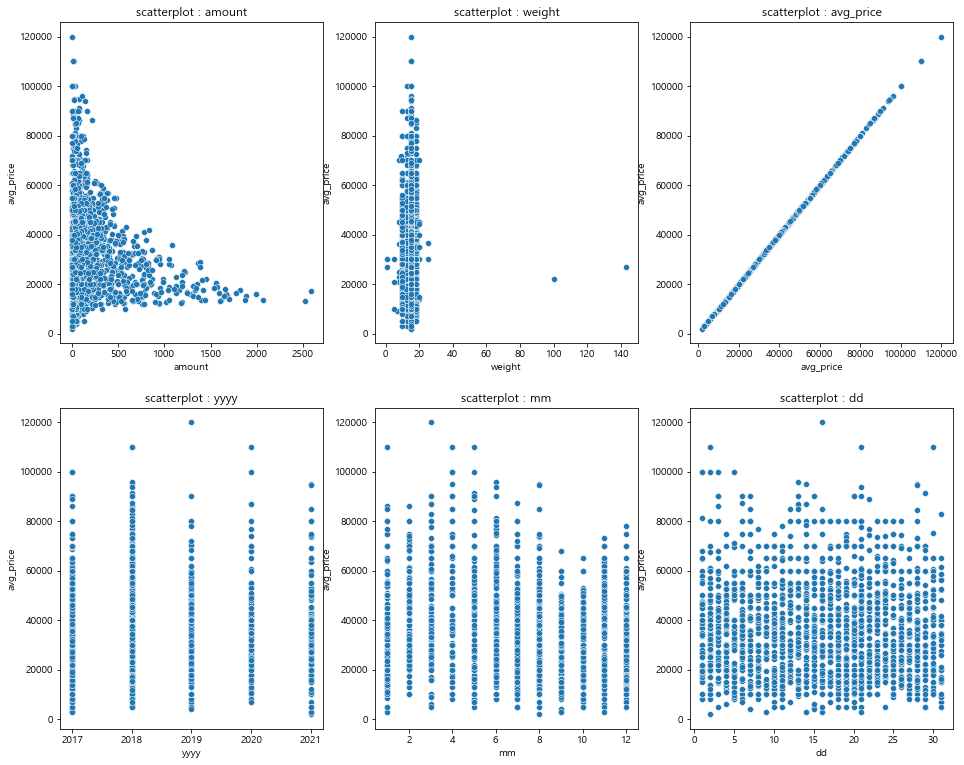

In [40]:
fig, ax = plt.subplots(nrows = 2, ncols =3)
fig.set_size_inches(16,13)
for i in range(len(num_gd_pdf.columns)):
    sns.scatterplot(data = num_gd_pdf, y = 'avg_price' ,x = num_gd_pdf.columns[i], ax= ax[int(i//3)][int(i%3)])
    ax[int(i//3)][int(i%3)].set_title("scatterplot : " + num_gd_pdf.columns[i])

plt.show()

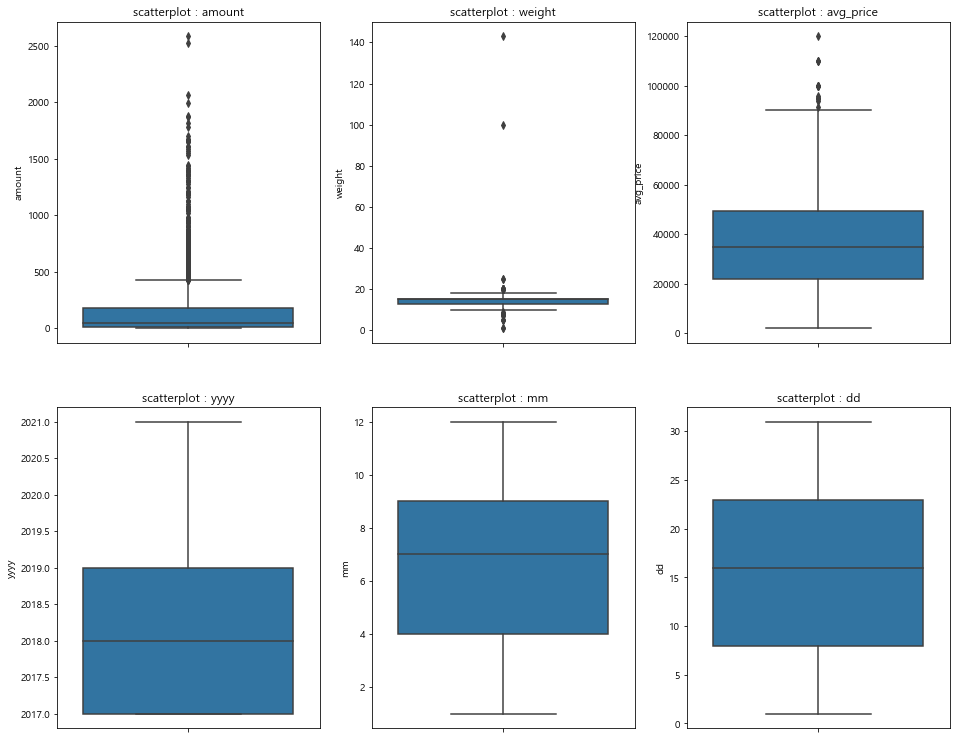

In [41]:
fig, ax = plt.subplots(nrows = 2, ncols =3)
fig.set_size_inches(16,13)
for i in range(len(num_gd_pdf.columns)):
    sns.boxplot(data = num_gd_pdf, y = num_gd_pdf.columns[i], ax= ax[int(i//3)][int(i%3)])
    ax[int(i//3)][int(i%3)].set_title("scatterplot : " + num_gd_pdf.columns[i])

plt.show()

### 결측치 제거

amout > 2500 이상 데이터 제거

In [42]:
gd_pdf['amount'].sort_values()

1593       1
5715       1
5724       1
5740       1
3814       1
        ... 
5546    1881
6409    1996
5312    2064
5521    2526
6536    2586
Name: amount, Length: 2043, dtype: int32

In [43]:
gd_pdf = gd_pdf[gd_pdf.amount < 2500]

weight > 100 이상 데이터 제거

In [44]:
gd_pdf['weight'].sort_values()

4008      1.0
6298      1.0
1089      5.0
8111      5.0
7412      5.0
        ...  
6806     20.0
4694     25.0
4693     25.0
2051    100.0
4056    143.0
Name: weight, Length: 2041, dtype: float64

In [45]:
gd_pdf = gd_pdf[gd_pdf.weight < 100]

avg_price >  이상 데이터 제거

In [46]:
gd_pdf['avg_price'].sort_values()

9550      2000
9804      3000
2267      3000
200       3000
9701      3000
         ...  
7721    100000
7520    110000
4536    110000
4405    110000
6719    120000
Name: avg_price, Length: 2039, dtype: int32

In [47]:
gd_pdf = gd_pdf[gd_pdf.avg_price < 100000]

In [49]:
gd_pdf.count()

amount           2030
weight           2030
avg_price        2030
yyyy             2030
mm               2030
dd               2030
origin_부산(기장)    2030
origin_삼천포       2030
origin_안흥        2030
origin_제주도       2030
origin_포항        2030
standard_18미     2030
standard_20미     2030
standard_28미     2030
standard_중       2030
dtype: int64

## 선형 회귀

In [50]:
gd_pdf.head()

,amount,weight,avg_price,yyyy,mm,dd,origin_부산(기장),origin_삼천포,origin_안흥,origin_제주도,origin_포항,standard_18미,standard_20미,standard_28미,standard_중
1,3,10.0,40000,2017,1,2,1,0,0,0,0,0,1,0,0
2,652,15.0,31800,2017,1,2,1,0,0,0,0,0,1,0,0
3,70,20.0,45000,2017,1,2,1,0,0,0,0,0,1,0,0
7,71,15.0,10000,2017,1,2,1,0,0,0,0,0,0,1,0
8,80,20.0,14000,2017,1,2,1,0,0,0,0,0,0,1,0


In [51]:
X = gd_pdf.drop(columns='avg_price')
y = gd_pdf['avg_price']

In [52]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 20, shuffle =True, test_size = 0.2)

In [53]:
gd_model_lr = LinearRegression()
gd_model_lr.fit(X_train, y_train)
gd_lr_y_pred = gd_model_lr.predict(X_test)

In [54]:
print(gd_model_lr.score(X_train, y_train))
print(gd_model_lr.score(X_test, y_test))

0.2934965436081265
0.27109829478766245


In [55]:
y_test = np.array(y_test)

In [56]:
MSE = mean_squared_error(y_test, gd_lr_y_pred)
RMSE = np.sqrt(MSE)
r2 = r2_score(y_test, gd_lr_y_pred)

print('MSE : {0:.5f}, RMSE : {1:.5f}'.format(MSE, RMSE))
print("r2_score : ", r2)

MSE : 240265811.85079, RMSE : 15500.51005
r2_score :  0.27109829478766245


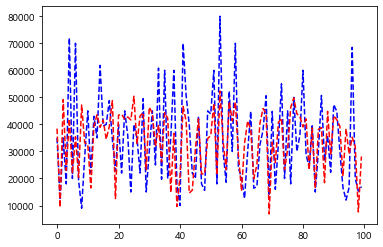

In [57]:
real = []
pred = []
index = []

for i in range(100):
  index.append(i)
  real.append(y_test[i])
  pred.append(gd_lr_y_pred[i])
  
plt.plot(index, real, 'b--', label="Real")
plt.plot(index, pred, 'r--', label="Pred")
plt.show()

In [64]:
# from sklearn.preprocessing import MinMaxScaler, StandardScaler

minmax_scaler = StandardScaler()
# minmax_scaler = MinMaxScaler()
minmax_scaler.fit(X_train)

x_train_scaled = minmax_scaler.transform(X_train)
x_test_scaled = minmax_scaler.transform(X_test)

In [65]:
gd_model_lr.fit(x_train_scaled, y_train)
gd_y_pred_scaled = gd_model_lr.predict(x_test_scaled)

In [66]:
MSE = mean_squared_error(y_test, gd_y_pred_scaled)
RMSE = np.sqrt(MSE)
r2 = r2_score(y_test, gd_y_pred_scaled)

print('MSE : {0:.5f}, RMSE : {1:.5f}'.format(MSE, RMSE))
print("r2_score : ", r2)

MSE : 240467931.98668, RMSE : 15507.02847
r2_score :  0.27048511678049614


## 랜덤포레스트

In [67]:
gd_model_rf = RandomForestRegressor()

gd_model_rf.fit(X_train, y_train)
gd_rf_y_pred = gd_model_rf.predict(X_test)

In [68]:
MSE = mean_squared_error(y_test, gd_rf_y_pred)
RMSE = np.sqrt(MSE)
r2 = r2_score(y_test, gd_rf_y_pred)

print('MSE : {0:.5f}, RMSE : {1:.5f}'.format(MSE, RMSE))
print("r2_score : ", r2)

MSE : 140700343.35468, RMSE : 11861.71756
r2_score :  0.573153086553674


In [86]:
rf_parameters = {
    'n_estimators': [100, 150, 200, 250],
    'max_depth': [None, 5, 6, 9, 12],
    # 'max_depth': [5, 6, 9, 12],
    # 'min_samples_split': [0.01, 0.02, 0.1, 0.15],
    # 'max_features': ['auto', 'sqrt'],
    'random_state':[99]
}

cv = KFold(n_splits=6)

rf = RandomForestRegressor()
rf_grid_cv = GridSearchCV(rf, param_grid=rf_parameters, cv=cv, n_jobs=-1, scoring='r2')
rf_grid_cv.fit(X_train, y_train)
 
 
print('최적 하이퍼 파라미터:', rf_grid_cv.best_params_)
print('최적 예측 정확도: {0:.4f}'.format(rf_grid_cv.best_score_))

최적 하이퍼 파라미터: {'max_depth': None, 'n_estimators': 200, 'random_state': 99}
최적 예측 정확도: 0.5166


In [70]:
gd_model_rf = rf_grid_cv.best_estimator_
gd_rf_y_pred = gd_model_rf.predict(X_test)

In [71]:
MSE = mean_squared_error(y_test, gd_rf_y_pred)
RMSE = np.sqrt(MSE)
r2 = r2_score(y_test, gd_rf_y_pred)

print('MSE : {0:.5f}, RMSE : {1:.5f}'.format(MSE, RMSE))
print("r2_score : ", r2)

MSE : 141959849.28473, RMSE : 11914.69048
r2_score :  0.5693320850842345


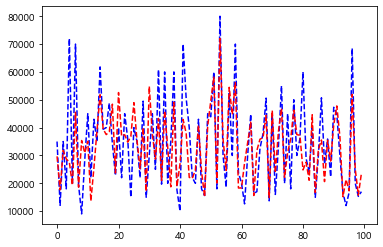

In [72]:
real = []
pred = []
index = []

for i in range(100):
  index.append(i)
  real.append(y_test[i])
  pred.append(gd_rf_y_pred[i])
  
plt.plot(index, real, 'b--', label="Real")
plt.plot(index, pred, 'r--', label="Pred")
plt.show()

## XGBRegressor

In [73]:
gd_model_xgb = XGBRegressor()

gd_model_xgb.fit(X_train, y_train)
gd_xgb_y_pred = gd_model_xgb.predict(X_test)

In [74]:
MSE = mean_squared_error(y_test, gd_xgb_y_pred)
RMSE = np.sqrt(MSE)
r2 = r2_score(y_test, gd_xgb_y_pred)

print('MSE : {0:.5f}, RMSE : {1:.5f}'.format(MSE, RMSE))
print("r2_score : ", r2)

MSE : 154725982.16204, RMSE : 12438.88991
r2_score :  0.5306030792737205


뭐지 스탠다드 스케일링 한 데이터 넣으니까 r2 개판됨

In [75]:
gd_model_xgb.fit(x_train_scaled, y_train)
gd_xgb_y_pred_scaled = gd_model_xgb.predict(X_test)

MSE = mean_squared_error(y_test, gd_xgb_y_pred_scaled)
RMSE = np.sqrt(MSE)
r2 = r2_score(y_test, gd_xgb_y_pred_scaled)

print('MSE : {0:.5f}, RMSE : {1:.5f}'.format(MSE, RMSE))
print("r2_score : ", r2)

MSE : 344711227.80258, RMSE : 18566.40051
r2_score :  -0.04576094208181791


xgb에 gcv 해본 것

In [76]:
xg_parameters ={'max_depth' : [3,4,5,6] , 
                # 'n_estimators': [12,24,32], 
                'n_estimators': [100,200,300], 
                'learning_rate':[0.01, 0.1], 
                # 'learning_rate':[0.1, 0.3, 0.5], 
                'gamma': [1, 2, 4], 
                'random_state':[99]}

xgb = XGBRegressor()
xgb_grid_cv = GridSearchCV(xgb, param_grid=xg_parameters, cv=6, n_jobs=-1, scoring='r2')
xgb_grid_cv.fit(X_train, y_train)
 
 
print('최적 하이퍼 파라미터:', xgb_grid_cv.best_params_)
print('최적 예측 정확도: {0:.4f}'.format(xgb_grid_cv.best_score_))


최적 하이퍼 파라미터: {'gamma': 1, 'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 200, 'random_state': 99}
최적 예측 정확도: 0.5308


In [77]:
gd_model_xgb = xgb_grid_cv.best_estimator_
gd_xgb_y_pred = gd_model_xgb.predict(X_test)

In [78]:
MSE = mean_squared_error(y_test, gd_xgb_y_pred)
RMSE = np.sqrt(MSE)
r2 = r2_score(y_test, gd_xgb_y_pred)

print('MSE : {0:.5f}, RMSE : {1:.5f}'.format(MSE, RMSE))
print("r2_score : ", r2)

MSE : 153560834.61897, RMSE : 12391.96654
r2_score :  0.5341378228330539


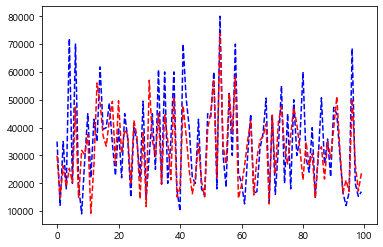

In [79]:
real = []
pred = []
index = []

for i in range(100):
  index.append(i)
  real.append(y_test[i])
  pred.append(gd_xgb_y_pred[i])
  
plt.plot(index, real, 'b--', label="Real")
plt.plot(index, pred, 'r--', label="Pred")
plt.show()

## lightGBM

In [80]:
gd_model_lgb = LGBMRegressor()

gd_model_lgb.fit(X_train, y_train)
gd_lgb_y_pred = gd_model_lgb.predict(X_test)

In [81]:
MSE = mean_squared_error(y_test, gd_lgb_y_pred)
RMSE = np.sqrt(MSE)
r2 = r2_score(y_test, gd_lgb_y_pred)

print('MSE : {0:.5f}, RMSE : {1:.5f}'.format(MSE, RMSE))
print("r2_score : ", r2)

MSE : 152596492.35089, RMSE : 12352.99528
r2_score :  0.5370633773187174


In [82]:
# lgb_parameters ={'max_depth' : [3,4,5,6] ,  
#                 'n_estimators': [100,300,500], 
#                 'learning_rate':[0.01, 0.05, 0.1],   
#                 'random_state':[99]}

lgb_parameters ={
    'n_estimators': [200, 500, 1000, 2000],
    'learning_rate': [0.1, 0.05, 0.01],
    'max_depth': [6, 7, 8],
    'colsample_bytree': [0.8, 0.9, 1.0],
    'subsample': [0.8, 0.9, 1.0] 
                }

lgb = LGBMRegressor()
lgb_grid_cv = GridSearchCV(lgb, param_grid=lgb_parameters, cv=6, n_jobs=-1, scoring='r2')
lgb_grid_cv.fit(X_train, y_train)
 
 
print('최적 하이퍼 파라미터:', lgb_grid_cv.best_params_)
print('최적 예측 정확도: {0:.4f}'.format(lgb_grid_cv.best_score_))

최적 하이퍼 파라미터: {'colsample_bytree': 0.8, 'learning_rate': 0.05, 'max_depth': 8, 'n_estimators': 200, 'subsample': 0.8}
최적 예측 정확도: 0.5314


In [83]:
gd_model_lgb = lgb_grid_cv.best_estimator_
gd_lgb_y_pred = gd_model_lgb.predict(X_test)

In [84]:
MSE = mean_squared_error(y_test, gd_lgb_y_pred)
RMSE = np.sqrt(MSE)
r2 = r2_score(y_test, gd_lgb_y_pred)

print('MSE : {0:.5f}, RMSE : {1:.5f}'.format(MSE, RMSE))
print("r2_score : ", r2)

MSE : 147915838.47756, RMSE : 12162.06555
r2_score :  0.5512632194164995


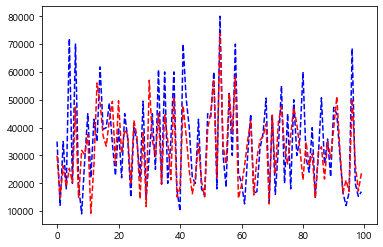

In [85]:
real = []
pred = []
index = []

for i in range(100):
  index.append(i)
  real.append(y_test[i])
  pred.append(gd_xgb_y_pred[i])
  
plt.plot(index, real, 'b--', label="Real")
plt.plot(index, pred, 'r--', label="Pred")
plt.show()